In [2]:
!pip install ucimlrepo pyarrow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load dataset
dataset = fetch_ucirepo(id=544)

In [4]:
# Split into features and targets
X = dataset.data.features
y = dataset.data.targets

In [5]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation


In [6]:
# Display datatypes
print(X.dtypes,'\n')
print(y.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object 

NObeyesdad    object
dtype: object


In [7]:
# Check for any missing values
print(X.isna().sum(), '\n')
print(y.isna().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64 

NObeyesdad    0
dtype: int64


In [8]:
# Binary to numeric
X['Gender'] = X['Gender'].map({'Female': 1, 'Male': 0})
X.rename(columns={'Gender': 'IsFemale?'}, inplace=True)

X['family_history_with_overweight'] = X['family_history_with_overweight'].map({'yes': 1, 'no': 0})
X['FAVC'] = X['FAVC'].map({'yes': 1, 'no': 0})
X['SMOKE'] = X['SMOKE'].map({'yes': 1, 'no': 0})
X['SCC'] = X['SCC'].map({'yes': 1, 'no': 0})

# Categorical to numeric
X['CAEC'] = X['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
X['CALC'] = X['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

# One-hot encode for transportation feature
X = pd.get_dummies(X, columns=['MTRANS'])

In [9]:
# Convert the target to binary (0 for not obese and 1 for obese)
y['NObeyesdad'] = y['NObeyesdad'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 0,
    'Overweight_Level_II': 0,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
})
y.rename(columns={'NObeyesdad': 'IsObese?'}, inplace=True)

In [10]:
# Convert all data types to integer
X = X.astype(int)
y = y.astype(int)

In [11]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()

# Apply both scalers (double normalization also used in KNN)
for col in X.columns:
    X[col] = scaler1.fit_transform(X[[col]])
    X[col] = scaler2.fit_transform(X[[col]])

In [12]:
# Split dataset into training and testing sets (stratified by obesity status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [14]:
# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['entropy']
}

In [15]:
# Label the evluation metrics for tuning
scoring_metrics = ['recall', 'f1', 'accuracy']

In [16]:
# Grid search for each metric
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
for metric in scoring_metrics:
    grid_search = GridSearchCV(
        rf,
        param_grid,
        scoring=metric,
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train.values.ravel())
    print(f"Best parameters for {metric}: {grid_search.best_params_}")

Best parameters for recall: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for f1: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for accuracy: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:

# Evaluate random forest with best parameters
def rf_funct(X, y, test_size=0.2,
             criterion='entropy',
             n_estimators=100,
             max_depth=None,
             min_samples_split=2,
             min_samples_leaf=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    rf = RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    rf.fit(X_train, y_train.values.ravel())

    y_pred = rf.predict(X_test)

    rec = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print(f"Sensitivity: {rec:.2f}")
    print(f"F1 Score: {F1:.2f}")
    print(f"Accuracy: {acc:.2f}")

In [18]:
# Final evaluation using best parameters found by gridsearchCV
rf_funct(X, y, criterion='entropy', n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)

Sensitivity: 0.98
F1 Score: 0.98
Accuracy: 0.98


In [19]:
# Cross Validate model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score

rf_best = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

scorers = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score)
}

for name, scorer in scorers.items():
    scores = cross_val_score(rf_best, X, y.values.ravel(), cv=5, scoring=scorer)
    print(f"{name.capitalize()} CV Scores: {scores}")
    print(f"{name.capitalize()} CV Mean: {scores.mean():.4f}")
    print('-'*40)

Recall CV Scores: [0.80512821 0.97938144 1.         1.         1.        ]
Recall CV Mean: 0.9569
----------------------------------------
F1 CV Scores: [0.88951841 0.98958333 1.         0.99487179 0.82278481]
F1 CV Mean: 0.9394
----------------------------------------
Accuracy CV Scores: [0.90780142 0.99052133 1.         0.99526066 0.80094787]
Accuracy CV Mean: 0.9389
----------------------------------------


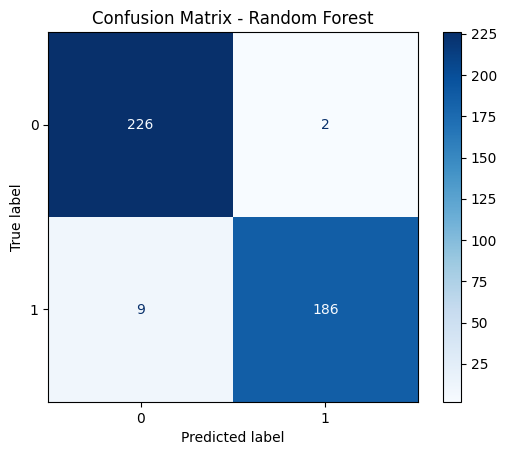

In [20]:
# Visualize Random Forest Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf_best.fit(X_train, y_train.values.ravel())
y_pred = rf_best.predict(X_test)

ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

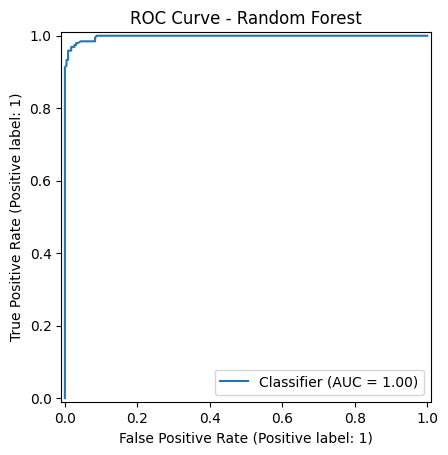

AUC Score: 0.9977


In [21]:
# Visualize Random Forest ROC Curve
y_probs = rf_best.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.title("ROC Curve - Random Forest")
plt.show()

auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")

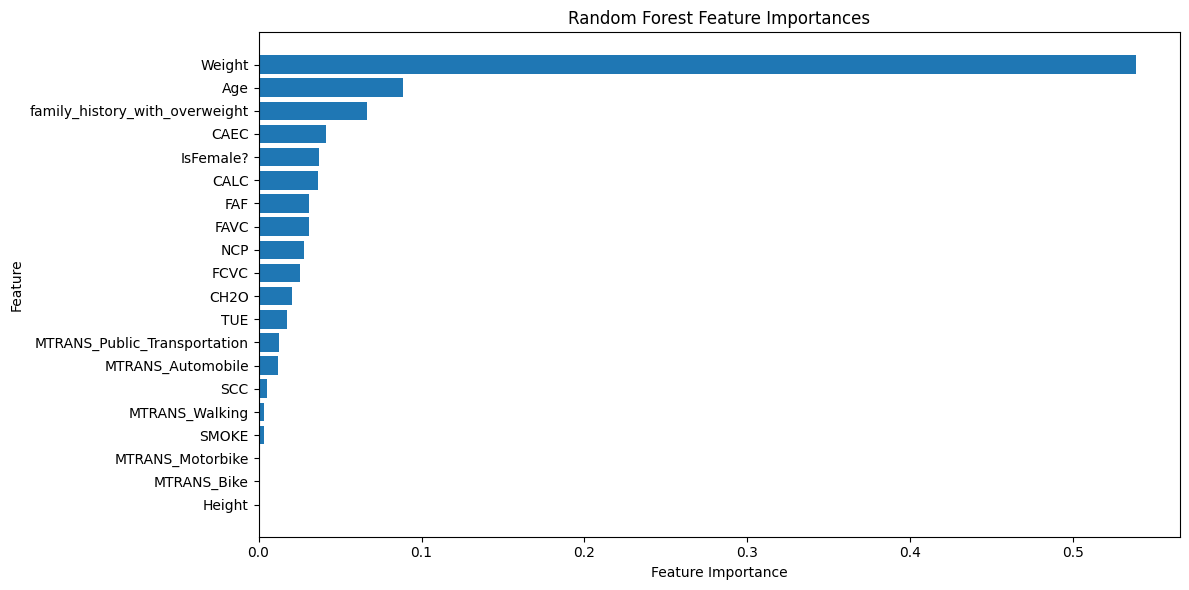

In [22]:
# Visualize Random Forest Feature Importance Model
rf_best.fit(X_train, y_train.values.ravel())

importances = rf_best.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()